# Toxicity Classification:

### 1. Business Problem:

Predicting the toxicity level of a comment . (0 -> not toxic, 1 -> highest toxicity level)<br><br>

### 2. Machine Learning Problem Formulation:

#### 2.1 Data: <br>

- Source: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data
- We have one single csv file for training and one cvs file to test.
- Columns in train data:
    - Comment_text: This is the data in string format which we have to use to find the toxicity.
    - target: Target values which are to be predicted (has values between 0 and 1)
    - Data also has additional toxicity subtype attributes: (Model does not have to predict these)
        - severe_toxicity
        - obscene
        - threat
        - insult
        - identity_attack
        - sexual_explicit
    - Comment_text data also has identity attributes carved out from it, some of which are:
        - male
        - female
        - homosexual_gay_or_lesbian
        - christian
        - jewish
        - muslim
        - black
        - white
        - asian
        - latino
        - psychiatric_or_mental_illness
    - Apart from above features the train data also provides meta-data from jigsaw like:
        - toxicity_annotator_count
        - identity_anotator_count
        - article_id
        - funny
        - sad
        - wow
        - likes
        - disagree
        - publication_id
        - parent_id
        - article_id
        - created_date
        

#### 2.2 Example Datapoints and Labels:<br>

**Comment:** i'm a white woman in my late 60's and believe me, they are not too crazy about me either!!<br><br>

- Toxicity Labels: All 0.0
- Identity Mention Labels: female: 1.0, white: 1.0 (all others 0.0)

**Comment:** You are an Idiot<br><br>

- Toxicity Labels: All 0.8
- Identity Mention Labels: female: 0.8 (all others 0.0)

**Comment:** Continue to stand strong LGBT community. Yes, indeed, you'll overcome and you have.<br><r>

- Toxicity Labels: All 0.0
- Identity Mention Labels: homosexual_gay_or_lesbian: 0.8, bisexual: 0.6, transgender: 0.3 (all others 0.0)



#### 2.3 Type of Machine Learning Problem:<br>

We have to predict the toxicity level(target attribute). The values range from 0 to 1 inclusive. This is a regression problem. It can also be treated as a classification problem if we take every value below 0.5 to be non-toxic and above it to be toxic, we would then get a binary classification problem.


## Importing Libraries:

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")
# K.tensorflow_backend._get_available_gpus()

C:\Users\LENOVO\anaconda3\envs\work\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Reading Data:

In [ ]:
train_df = pd.read_csv('train.csv', index_col='id', engine='python')
train_df.head()

target                                       comment_text  \
id                                                                   
59848  0.000000  This is so cool. It's like, 'would you want yo...   
59849  0.000000  Thank you!! This would make my life a lot less...   
59852  0.000000  This is such an urgent design problem; kudos t...   
59855  0.000000  Is this something I'll be able to install on m...   
59856  0.893617               haha you guys are a bunch of losers.   

       severe_toxicity  obscene  identity_attack   insult  threat  asian  \
id                                                                         
59848         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59849         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59852         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59855         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59856         0.021277      0.0         0.021277  0.87234     0.0    0.0   

       atheist  bisexual  ...  article_id    rating  funny  wow  sad  likes  \
id                        ...                                                 
59848      NaN       NaN  ...        2006  rejected      0    0    0      0   
59849      NaN       NaN  ...        2006  rejected      0    0    0      0   
59852      NaN       NaN  ...        2006  rejected      0    0    0      0   
59855      NaN       NaN  ...        2006  rejected      0    0    0      0   
59856      0.0       0.0  ...        2006  rejected      0    0    0      1   

       disagree  sexual_explicit  identity_annotator_count  \
id                                                           
59848         0              0.0                         0   
59849         0              0.0                         0   
59852         0              0.0                         0   
59855         0              0.0                         0   
59856         0              0.0                         4   

       toxicity_annotator_count  
id                               
59848                         4  
59849                         4  
59852                         4  
59855                         4  
59856                        47  

[5 rows x 44 columns]

In [ ]:
test_df = pd.read_csv('test.csv', index_col='id', engine='python')
test_df.head()

comment_text
id                                                        
7097320  [ Integrity means that you pay your debts.]\n\...
7097321  This is malfeasance by the Administrator and t...
7097322  @Rmiller101 - Spoken like a true elitist. But ...
7097323  Paul: Thank you for your kind words.  I do, in...
7097324  Sorry you missed high school. Eisenhower sent ...

In [ ]:
train_df.describe()

target  severe_toxicity       obscene  identity_attack  \
count  1.804874e+06     1.804874e+06  1.804874e+06     1.804874e+06   
mean   1.030173e-01     4.582099e-03  1.387721e-02     2.263571e-02   
std    1.970757e-01     2.286128e-02  6.460419e-02     7.873156e-02   
min    0.000000e+00     0.000000e+00  0.000000e+00     0.000000e+00   
25%    0.000000e+00     0.000000e+00  0.000000e+00     0.000000e+00   
50%    0.000000e+00     0.000000e+00  0.000000e+00     0.000000e+00   
75%    1.666667e-01     0.000000e+00  0.000000e+00     0.000000e+00   
max    1.000000e+00     1.000000e+00  1.000000e+00     1.000000e+00   

             insult        threat          asian        atheist  \
count  1.804874e+06  1.804874e+06  405130.000000  405130.000000   
mean   8.115273e-02  9.311271e-03       0.011964       0.003205   
std    1.760657e-01  4.942218e-02       0.087166       0.050193   
min    0.000000e+00  0.000000e+00       0.000000       0.000000   
25%    0.000000e+00  0.000000e+00       0.000000       0.000000   
50%    0.000000e+00  0.000000e+00       0.000000       0.000000   
75%    9.090909e-02  0.000000e+00       0.000000       0.000000   
max    1.000000e+00  1.000000e+00       1.000000       1.000000   

            bisexual          black  ...     parent_id    article_id  \
count  405130.000000  405130.000000  ...  1.026228e+06  1.804874e+06   
mean        0.001884       0.034393  ...  3.722687e+06  2.813597e+05   
std         0.026077       0.167900  ...  2.450261e+06  1.039293e+05   
min         0.000000       0.000000  ...  6.100600e+04  2.006000e+03   
25%         0.000000       0.000000  ...  7.960188e+05  1.601200e+05   
50%         0.000000       0.000000  ...  5.222993e+06  3.321260e+05   
75%         0.000000       0.000000  ...  5.775758e+06  3.662370e+05   
max         1.000000       1.000000  ...  6.333965e+06  3.995410e+05   

              funny           wow           sad         likes      disagree  \
count  1.804874e+06  1.804874e+06  1.804874e+06  1.804874e+06  1.804874e+06   
mean   2.779269e-01  4.420696e-02  1.091173e-01  2.446167e+00  5.843688e-01   
std    1.055313e+00  2.449359e-01  4.555363e-01  4.727924e+00  1.866589e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  3.000000e+00  0.000000e+00   
max    1.020000e+02  2.100000e+01  3.100000e+01  3.000000e+02  1.870000e+02   

       sexual_explicit  identity_annotator_count  toxicity_annotator_count  
count     1.804874e+06              1.804874e+06              1.804874e+06  
mean      6.605974e-03              1.439019e+00              8.784694e+00  
std       4.529782e-02              1.787041e+01              4.350086e+01  
min       0.000000e+00              0.000000e+00              3.000000e+00  
25%       0.000000e+00              0.000000e+00              4.000000e+00  
50%       0.000000e+00              0.000000e+00              4.000000e+00  
75%       0.000000e+00              0.000000e+00              6.000000e+00  
max       1.000000e+00              1.866000e+03              4.936000e+03  

[8 rows x 41 columns]

**Looking at count values of asian,atheist etc columns we see that there are a lot of Null values present, but this is OK as we are only supposed to use 'comment_text' column so dealing with these is not really necessary here.**

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                       

In [ ]:
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

**No Null values for target and comment_text columns**

In [ ]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804874, 44) (97320, 1)


## Exploratory Data Analysis:

### 1. Target Feature:

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

In [ ]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

# Plot the number and percentage of toxic and non-toxic comments.
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

# Plot the count plot.
cntplot = sns.countplot(temp)
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**The dataset is imbalanced as 92% of the comments are non-toxic and only 8% are toxic**

### 2. Toxicity Subtype Features:
- severe_toxicity
- obscene
- threat
- insult
- identity_attack

In [ ]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit according to my needs
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

In [ ]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

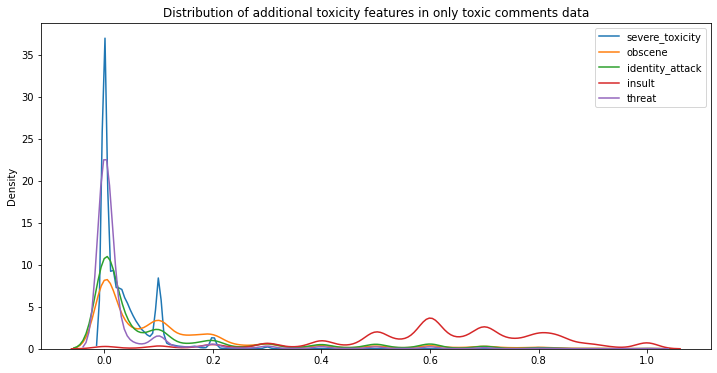

In [ ]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

**We see that for toxic comments data, there are more insulting comments as compared to obscene comments**

In [ ]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

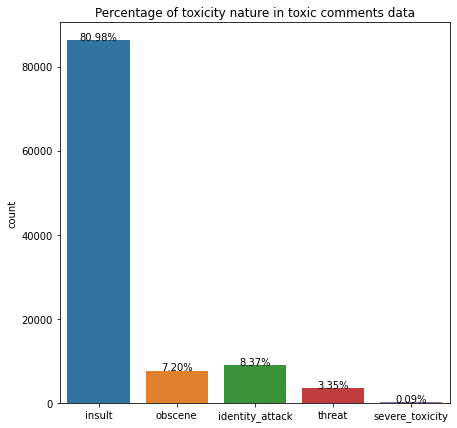

In [ ]:
x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment
fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**In our train dataset only 8% of the data was toxic. Out of that 8%, 81% of the toxic comments made are insults, 8.37% are identity attacks, 7.20% are obscene, 3.35% are threats and a very small amount of toxic comments are severly toxic.**

### 3. Identity Attributes:

Sensitive topics:

- male
- female
- homosexual_gay_or_lesbian
- bisexual
- heterosexual
- christian
- jewish
- muslim
- black
- white
- asian
- latino

In [ ]:
temp = train_df.dropna(axis = 0, how = 'any')

In [ ]:
features = ['male', 'female', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender feature values", temp)

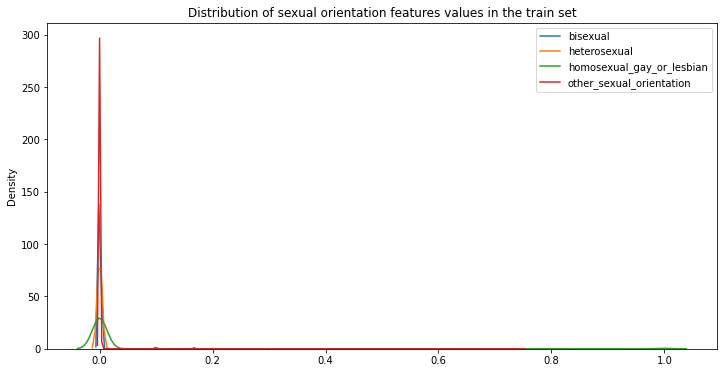

In [ ]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

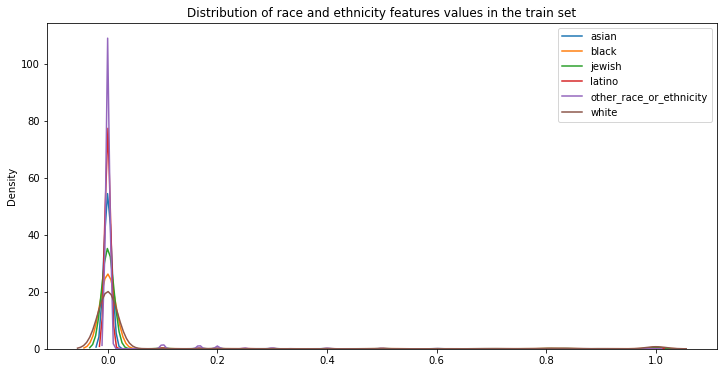

In [ ]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

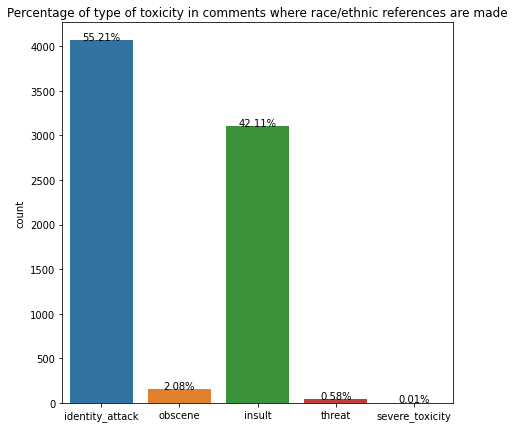

In [ ]:
# Get data where race/ethnic references are made.
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where race/ethnic references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**We see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.**

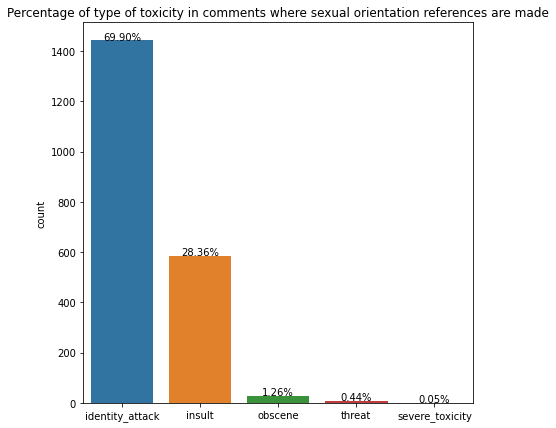

In [ ]:
# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.** 

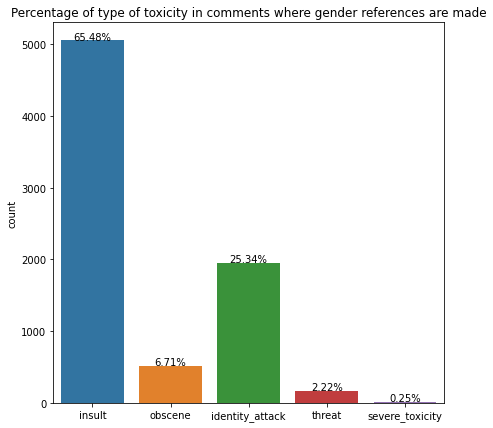

In [ ]:
# Get data where race/ethnic references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

### 4. Features generated by users feedback:

- funny
- sad
- wow
- likes
- disagree

In [ ]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit
def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

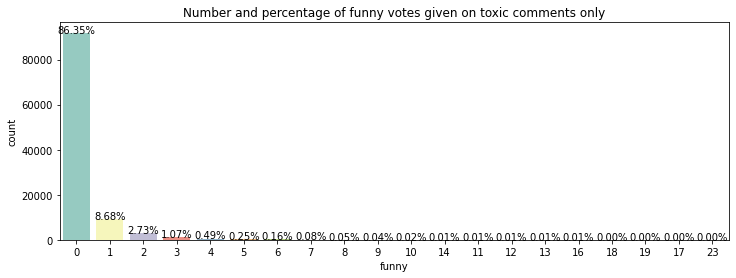

In [ ]:
plot_count('funny','funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

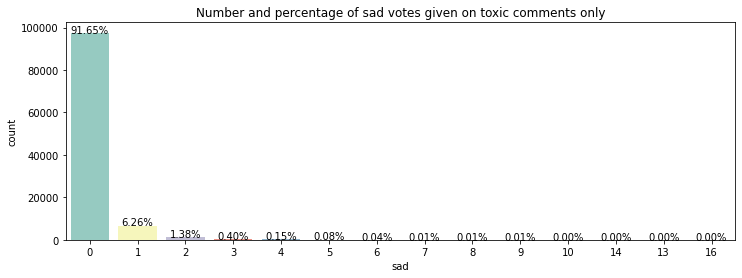

In [ ]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

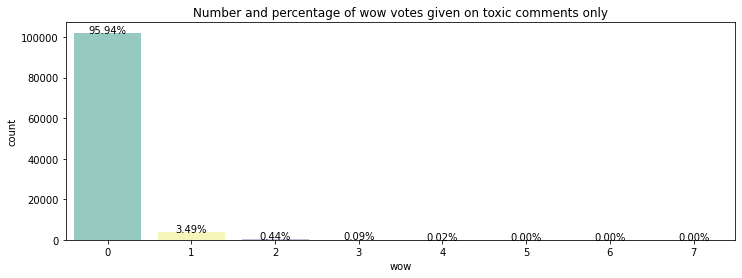

In [ ]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

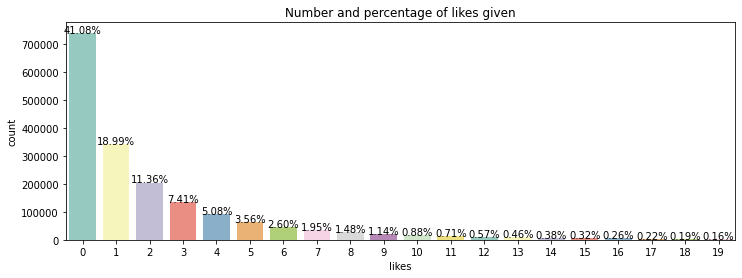

In [ ]:
plot_count('likes','likes given', train_df, 3)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

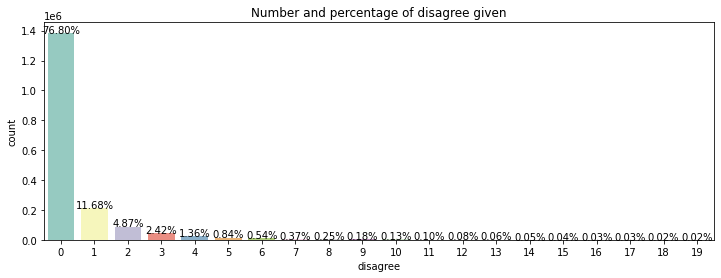

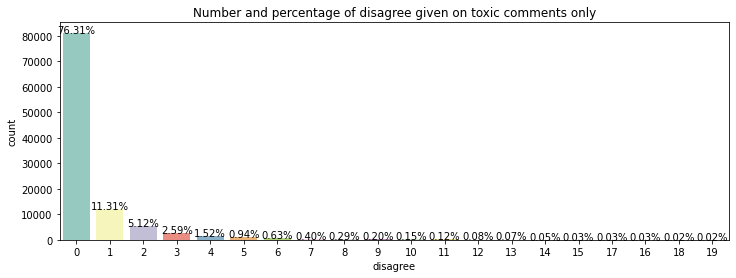

In [ ]:
plot_count('disagree','disagree given', train_df, 3)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

### 5. Comments_text Feature:

In [ ]:
# Code From: https://www.kaggle.com/gpreda/jigsaw-eda
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

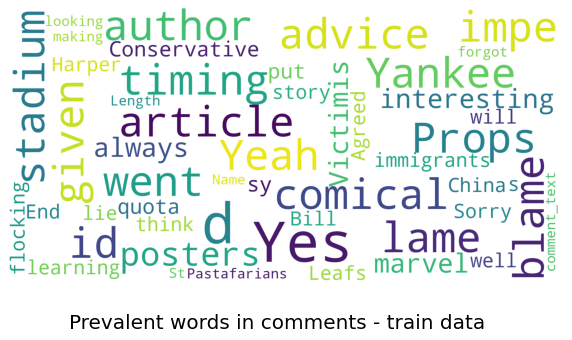

In [ ]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

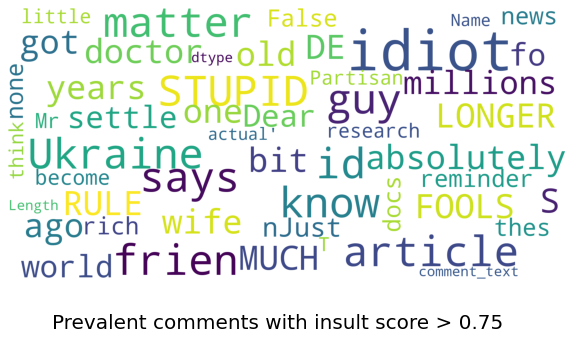

In [ ]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

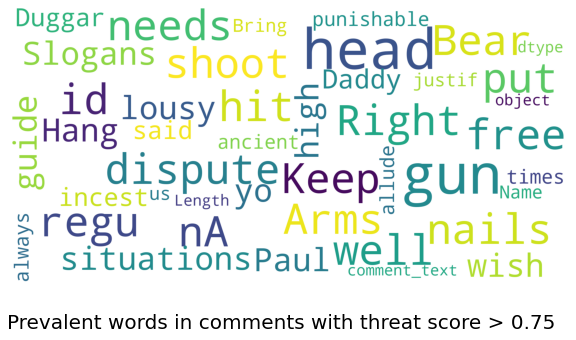

In [ ]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

In [ ]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

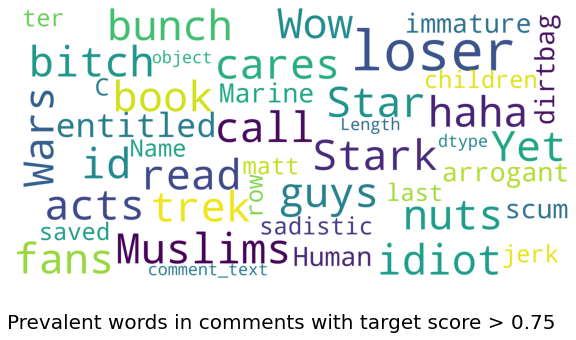

In [ ]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

In [ ]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

In [ ]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

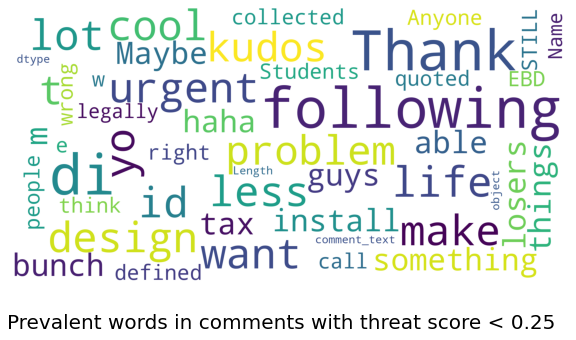

In [ ]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

In [ ]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

## Preprocessing Text and Train-Test Split:

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [ ]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [ ]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

CPU times: total: 17min 34s
Wall time: 17min 34s


In [ ]:
train_df.head()

target                                       comment_text  \
id                                                                   
59848  0.000000  This is so cool. It's like, 'would you want yo...   
59849  0.000000  Thank you!! This would make my life a lot less...   
59852  0.000000  This is such an urgent design problem; kudos t...   
59855  0.000000  Is this something I'll be able to install on m...   
59856  0.893617               haha you guys are a bunch of losers.   

       severe_toxicity  obscene  identity_attack   insult  threat  asian  \
id                                                                         
59848         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59849         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59852         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59855         0.000000      0.0         0.000000  0.00000     0.0    NaN   
59856         0.021277      0.0         0.021277  0.87234     0.0    0.0   

       atheist  bisexual  ...    rating  funny  wow  sad  likes  disagree  \
id                        ...                                               
59848      NaN       NaN  ...  rejected      0    0    0      0         0   
59849      NaN       NaN  ...  rejected      0    0    0      0         0   
59852      NaN       NaN  ...  rejected      0    0    0      0         0   
59855      NaN       NaN  ...  rejected      0    0    0      0         0   
59856      0.0       0.0  ...  rejected      0    0    0      1         0   

       sexual_explicit  identity_annotator_count  toxicity_annotator_count  \
id                                                                           
59848              0.0                         0                         4   
59849              0.0                         0                         4   
59852              0.0                         0                         4   
59855              0.0                         0                         4   
59856              0.0                         4                        47   

                                       preprocessed_text  
id                                                        
59848  cool like would want mother read realli great ...  
59849  thank would make life lot less anxieti induc k...  
59852            urgent design problem kudo take impress  
59855                      someth abl instal site releas  
59856                               haha guy bunch loser  

[5 rows x 45 columns]

In [ ]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: total: 54.6 s
Wall time: 54.6 s


In [ ]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [ ]:
X_train.head()

preprocessed_text
id                                                        
5456163  look recent file sedar look balanc sheet state...
6027823  believ pretti obvious alli guy peopl read post...
5650568  reason khadr aliv enjoy 10 5 million today res...
5668696  thing revers progress unconstitut govern artic...
5874835  think colt mind current kicker adam vinatieri ...

In [ ]:
X_cv.head()

preprocessed_text
id                                                        
764757                      western spoken like ignor fool
267314   20 k bail third parti custodian unbeliev arm r...
478234         hillari clinton make look honest comparison
5605976  depart simpli control selfi 2 minist agre anyt...
1075857  hey justin unless repeal approv km expans site...

In [ ]:
X_test = test_df[['preprocessed_text']]
X_test.head()

preprocessed_text
id                                                        
7097320            integr mean pay debt appli presid trump
7097321                 malfeas administr board wast money
7097322  rmiller101 spoken like true elitist look bud a...
7097323  paul thank kind word inde strong belief hide b...
7097324  sorri miss high school eisenhow sent troop vie...

In [ ]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

## Training Models:

In [ ]:
# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

### 1. Bag of Words (BoW):

In [ ]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### 1.1 SGDRegressor:

##### 1.1.1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.022857715652626627
Mean Squared Error on cv set:  0.022963294576630214
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.5916888937031577
Mean Squared Error on cv set:  0.036435321366761586
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.024493344273371808
Mean Squared Error on cv set:  0.024491891244583088
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.5401469044391369
Mean Squared Error on cv set:  0.03503628059943117
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03147379226154613
Mean Squared Error on cv set:  0.03127664934728845
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.04315627982785707
Mean Squared Error on cv set:  0.023918982054084575
*******************************************

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 1e-05,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### 1.1.2 Feature Importance:

In [ ]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

weights
idiot     0.426688
stupid    0.342961
moron     0.322709
pathet    0.303637
crap      0.286269
ass       0.273996
hypocrit  0.271467
dumb      0.263359
scum      0.261438
jerk      0.259685
shit      0.251920
clown     0.245627
damn      0.228899
buffoon   0.224118
fool      0.217957
imbecil   0.212300
silli     0.210954
loser     0.209795
scumbag   0.200895
rubbish   0.196861

In [ ]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

weights
stupid stupid    -0.074992
knee jerk        -0.066403
fool peopl       -0.046402
black white      -0.045114
ignor fact       -0.039520
winner loser     -0.033309
white hous       -0.028694
peopl time       -0.027901
black market     -0.027728
mental health    -0.021379
mass shoot       -0.020572
authoritarian    -0.019439
give damn        -0.018874
men women        -0.017572
get sick         -0.017182
well said        -0.016977
knee             -0.016659
terrorist attack -0.016485
can              -0.016254
winner           -0.016228

#### 1.2 Decision Trees:

##### 1.2.1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.033152688510157347
Mean Squared Error on cv set:  0.03296825405665669
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03315268851015735
Mean Squared Error on cv set:  0.03296825405665668
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03315597757762933
Mean Squared Error on cv set:  0.03296489250172905
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03206473440597162
Mean Squared Error on cv set:  0.03192820550786619
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03206853705585131
Mean Squared Error on cv set:  0.031923051652315404
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on trai

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

##### 1.2.2 Feature Importance:

In [ ]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

weights
stupid      0.397848
idiot       0.264155
pathet      0.070291
fool        0.069067
moron       0.063123
racist      0.059856
crap        0.054813
would       0.004297
year        0.003427
one         0.003148
peopl       0.001887
white       0.001497
time        0.001321
even        0.001208
use         0.000568
get         0.000509
good        0.000498
work        0.000484
us          0.000470
fool peopl  0.000374

### 2. Term Frequency - Inverse Document Frequency (TFIDF) :

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### 2.1 SGDRegressor:

##### 2.1.1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.025281794925947024
Mean Squared Error on cv set:  0.0251804583170457
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.023910440065576806
Mean Squared Error on cv set:  0.023874469500170453
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.02974445022569698
Mean Squared Error on cv set:  0.02958190986810247
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.025035990636768295
Mean Squared Error on cv set:  0.024971490737618767
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.038348939992882955
Mean Squared Error on cv set:  0.038083720701657796
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.030094238492982033
Mean Squared Error on cv set:  0.029932032642352835
***************************************

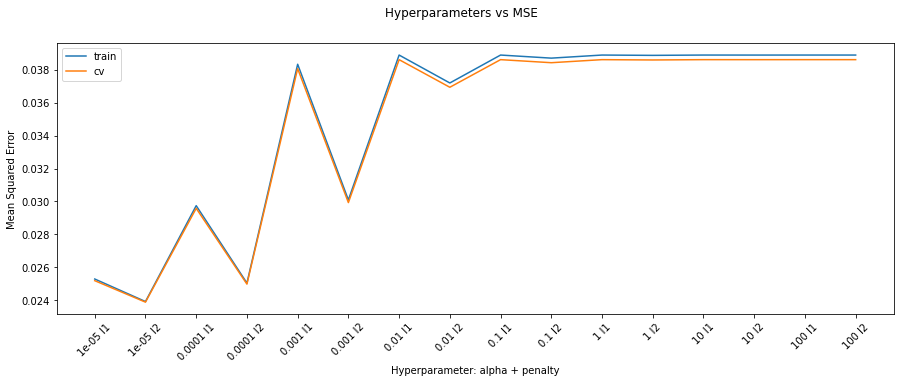

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.1.2 Feature Importance:

In [ ]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

weights
stupid    1.571238
idiot     1.271234
fool      0.667622
ignor     0.606185
dumb      0.598173
pathet    0.591460
moron     0.573057
ridicul   0.562645
loser     0.549593
liar      0.522134
crap      0.518321
hypocrit  0.515025
racist    0.503755
white     0.483397
troll     0.447583
kill      0.446442
damn      0.445630
clown     0.439236
silli     0.431981
black     0.426327

In [ ]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

weights
thank    -0.094295
interest -0.084583
agre     -0.076941
may      -0.076016
stori    -0.075813
great    -0.073833
good     -0.070032
new      -0.069290
issu     -0.068915
point    -0.067900
differ   -0.067685
com      -0.065659
work     -0.065637
chang    -0.064489
year     -0.063973
http     -0.062310
happen   -0.062308
articl   -0.061916
number   -0.060610
provid   -0.060287

#### 2.2 Decision Trees:

##### 2.2.1 Hyperparameter Tuning:

In [ ]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03294395394248843
Mean Squared Error on cv set:  0.03277835774423555
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.032943953942488426
Mean Squared Error on cv set:  0.03277835774423555
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.032943953942488426
Mean Squared Error on cv set:  0.03277835774423555
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03179869641272053
Mean Squared Error on cv set:  0.0316426704079428
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03179936562906118
Mean Squared Error on cv set:  0.03164148771426547
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train

In [ ]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.2.2 Feature Importance:

In [ ]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

weights
stupid      0.404951
idiot       0.266504
fool        0.073307
pathet      0.070149
moron       0.063576
white       0.057781
hypocrit    0.053481
racist      0.005510
ignor       0.000935
trump       0.000616
peopl       0.000609
twice       0.000511
fool peopl  0.000337
countri     0.000222
loser       0.000205
support     0.000103
signific    0.000095
whether     0.000092
without     0.000083
like        0.000080

In [ ]:
import joblib
 
# Save the model as a pickle in a file
joblib.dump(best_model, 'best_model.pkl')
 
# Load the model from the file
best_model_from_joblib = joblib.load('best_model.pkl')
 
# Use the loaded model to make predictions
# best_model_from_joblib.predict(tfidf_train)

array([0.0856569, 0.0856569, 0.0856569, ..., 0.0856569, 0.0856569,
       0.0856569])

### 3. Features for LSTM:

In [ ]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [ ]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [ ]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [ ]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

(1353655, 350)
(451219, 350)
(97320, 350)


In [ ]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [ ]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(CuDNNLSTM(128, return_sequences=True))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          20152300  
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 350, 128)          117760    
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 128)               132096    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 20,402,285
Trainable params: 20,402,285
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 350, 100)          20152300  
                                                                 
 lstm (LSTM)                 (None, 350, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,401,261
Trainable params: 20,401,261
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# history = model.fit(lstm_train, y_train, nb_epoch=5,
#                     batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

history = model.fit(lstm_train, y_train, epochs=5,
                    batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

Epoch 1/5
 25/661 [>.............................] - ETA: 10:56:41 - loss: 0.0525 - mse: 0.0525

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

## Conclusions:



1. **BagOfWords:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02281
        - CV MSE Loss: 0.02326
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.0310
        - CV MSE Loss: 0.03128
2. **TFIDF:**
    - _SGDRegressor:_
        - Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
        - Train MSE Loss: 0.02556
        - CV MSE Loss: 0.02584
    - _Decision Tree:_
        - Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
        - Train MSE Loss: 0.03073
        - CV MSE Loss: 0.03122
3. **LSTM:**
    - Train MSE Loss: 0.0157
    - CV MSE Loss: 0.0162